In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

---
Define some simple utilities.

In [2]:
def row_to_column(row):
    if type(row) == type(pd.Series()):
        return pd.DataFrame(row)
    elif type(row) == type(np.empty(0)):
        return row.reshape(-1,1)
    else:
        raise ValueError("row_to_column expected pandas Series or 1D numpy array")
        
class Row_Flipper(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        if len(X.shape) != 1:
            raise ValueError('RowFlipper expected 1D object, but got argument of shape {X.shape}')
        return row_to_column(X)

---
## Load in the training data.
The test-dataset is in the same directory and is not loaded in this notebook.

In [18]:
data_trainval = pd.read_csv(os.path.join('data', 'train.csv'))

---
Copy the column description from
https://www.kaggle.com/c/titanic/data

Note the meaning of *SibSp* and *Parch*.


Variable | Definition | Key
--- | --- | ---
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex |  	
Age | Age in years |
sibsp |	# of siblings / spouses aboard the Titanic 	
parch | # of parents / children aboard the Titanic 	
ticket | Ticket number 	
fare | Passenger fare 	
cabin | Cabin number 	
embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton

---
Have a quick look at the number of records, types of variables and the fraction and placement of missing values.

In [19]:
data_trainval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


There are no missing values in the majority of columns.

---
## Train - val split
Split the traininig dataset into features that will be used for classification (X_train) and the labels (y_train). Split the training set further into proper *train* and *validation* in 4:1 proportion, using stratification based on frequencies of the binary y labels.

In [20]:
X_trainval = data_trainval[data_trainval.columns.drop('Survived')]
y_trainval = data_trainval.Survived

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify = y_trainval, random_state=42)

In [21]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 11), (179, 11), (712,), (179,))

In [22]:
print(y_train.value_counts(normalize=True))
y_val.value_counts(normalize=True)

0    0.616573
1    0.383427
Name: Survived, dtype: float64


0    0.614525
1    0.385475
Name: Survived, dtype: float64

---
## Count the missing values.
There are many in two columns: *Age* and *Cabin*, few in the *Embarked*, and none in other columns. Let's leave them for now.

In [23]:
X_train.isnull().sum() / len(X_train)

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.192416
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.775281
Embarked       0.002809
dtype: float64

In [24]:
X_train.Embarked.isnull().sum()

2

---
## Examine *PassengerId*
PassengerId values are unique and equal to the (index + 1). Hence, we will ignore PassengerId in the analysis. The *y_train* already shares common index with *X_train*.

In [25]:
(np.array(X_train.PassengerId) == np.array(X_train.index) + 1).all()

True

In [26]:
X_train = X_train.drop('PassengerId', axis=1)

---
## Provisionally split the features into numerical and categorical
Start by splitting solely based on the datatype.

In [27]:
X_train.dtypes.value_counts()

object     5
int64      3
float64    2
dtype: int64

In [28]:
numerical_columns = [column for column in X_train if X_train[column].dtype in ['float64', 'int64']]
categorical_columns = [column for column in X_train if X_train[column].dtype in ['object']]

In [31]:
numerical_columns

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [32]:
categorical_columns

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

We already know that *Pclass* is a dicrete variable that takes values from a three-element sequence: (3, 2, 1). It is not obvious, whether it's better to treat those values as independent categories or rather as points in a one-dimensional continous space. But the former approach seems more sensible given that there are only three values which probably corresponded to qualitatively different situations of the passangers.

In [33]:
numerical_columns.remove('Pclass')

In [34]:
categorical_columns.append('Pclass')

---
---
## Examine the numerical features

In [35]:
X_train[numerical_columns].describe()

,Age,SibSp,Parch,Fare
count,575.000000,712.000000,712.000000,712.000000
mean,29.807687,0.492978,0.390449,31.819826
std,14.485211,1.060720,0.838134,48.059104
min,0.420000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.895800
50%,28.500000,0.000000,0.000000,14.454200
75%,39.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


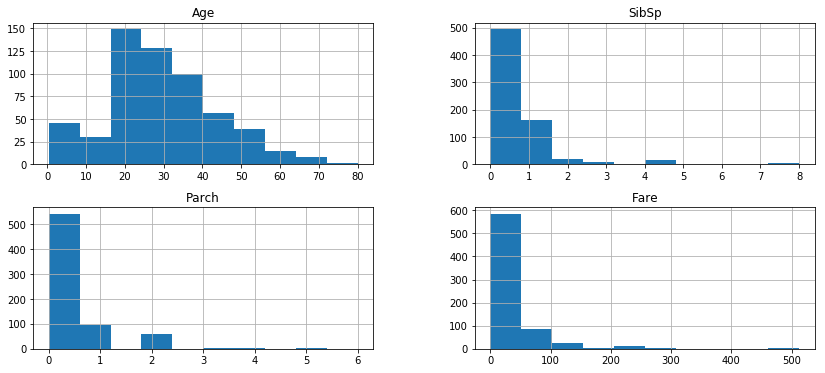

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(14,6))
axes = axes.flatten()
# axes[-1].remove()

for index, column in enumerate(numerical_columns):
    X_train.hist(column=column, ax=axes[index])

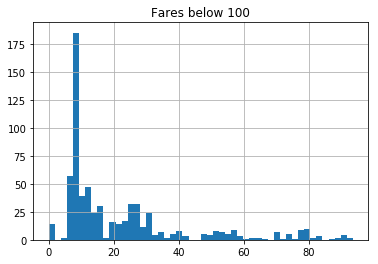

In [37]:
pd.DataFrame({'Fares below 100': X_train.Fare[X_train.Fare<100]}).hist(bins=50)
plt.show()

Recalling that there is a significant fraction of records with missing 'Age', and given the context of our analysis, is seems reasonable to split age into unordered categories. This way we can treat 'missing' as just another category next to 'children', 'adults' etc.

There already is a class in sklearn that serves to dicretize numerical variables (*KBinsDicretizer*) but it does not handle missing values and doesn't seem to allow for handpicked bins. Hence, it will be easier to define our own *Discretizer*. Notice that it is a stateless transformer (the *fit* methoed doen't do anything).

In [38]:
class Discretizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, name, tresholds, handle_missing=True):
        
        self.name = name
        self.tresholds = tresholds
        self.handle_missing = handle_missing
        
        self.columns = []
        self.inf_tresholds = [-np.inf] + tresholds + [np.inf]
        
        for index in range(len(self.inf_tresholds) - 1):
            self.columns.append(f"{self.name}_({self.inf_tresholds[index]},{self.inf_tresholds[index+1]}]")
        if self.handle_missing:
            self.columns.append(f"{self.name}_missing")
        
        return None
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        
        one_hots = np.zeros( (len(self.inf_tresholds) - 1 + int(self.handle_missing), len(X)) )
        for index in range(len(self.inf_tresholds) - 1):
            one_hots[index] = (X > self.inf_tresholds[index]) & (X <= self.inf_tresholds[index + 1])
            
        if self.handle_missing:
            one_hots[len(self.inf_tresholds) - 1] = X.isnull()
        elif X.isnull().any():
            raise ValueError("There's NAN's in the input")

        result = pd.DataFrame(one_hots.T, columns=self.columns, index = X.index)
            
        return result

Now we can do for example the following. (Note that we retain the freedom of tuning the tresholds later.)

In [39]:
age_discretizer = Discretizer('age', tresholds = [5, 10, 20, 30, 40, 50])
X_train.Age[2:5]

527     NaN
855    18.0
801    31.0
Name: Age, dtype: float64

In [40]:
age_discretizer.transform(X_train.Age[2:5])

,"age_(-inf,5]","age_(5,10]","age_(10,20]","age_(20,30]","age_(30,40]","age_(40,50]","age_(50,inf]",age_missing
527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
855,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
801,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


We can use the same class to bin and one-hot-encode the *SibSp* and *Parch* variables. We will assume that there are no missing values in those features, and so we just want an error raised otherwise.

In [41]:
sibsp_discretizer = Discretizer('sibsp', tresholds = [0,1], handle_missing=False)
parch_discretizer = Discretizer('parch', tresholds = [0], handle_missing=False)

In [42]:
sibsp_discretizer.transform(X_train.SibSp).mean()

sibsp_(-inf,0]    0.693820
sibsp_(0,1]       0.230337
sibsp_(1,inf]     0.075843
dtype: float64

In [43]:
parch_discretizer.transform(X_train.Parch).mean()

parch_(-inf,0]    0.761236
parch_(0,inf]     0.238764
dtype: float64

Finally, the last numerical feature left: the Fare. Conceptually it as a continous, nonegative quantity (interestingly there are some zero values). We can see that its distribution is rather far from a normal one. One could apply the Yeo-Johnson transformation to it (see *PowerTransformer*) to make it more gaussian. But, for the sake of keeping things simple, let's just use the function $x \to \log(1 + x)$, using the *numpy*'s build-in *log1p*, and then squeeze the result into an interval centered at 0.5 using the *MinMaxScaler*.

In [44]:
X_train.Fare.skew()

4.64618995113625

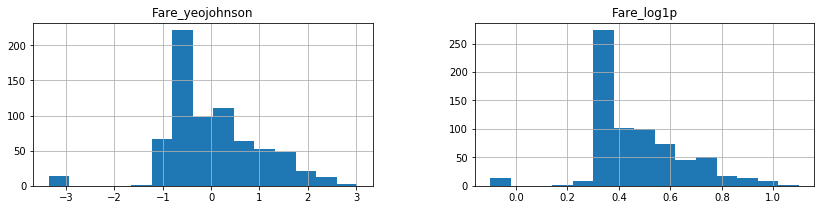

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(14,3))
bins = 15

yeojohnson = PowerTransformer(method='yeo-johnson')
pd.DataFrame({'Fare_yeojohnson': yeojohnson.fit_transform(X_train.Fare.values.reshape(-1,1)).reshape(-1)}).hist(ax = axes[0], bins=bins)

def fare_transformer(delta=0.5):
    range_ = (0.5-delta, 0.5+delta)
    return make_pipeline(FunctionTransformer(np.log1p, validate=False), Row_Flipper(), MinMaxScaler(feature_range = range_))

pd.DataFrame(fare_transformer(0.6).fit_transform(X_train.Fare)).rename(columns = {0: 'Fare_log1p'}).hist(ax = axes[1], bins=bins)

plt.show()

Notice that we have not hardcoded any value for the *delta* parameter above.

### Summary of the numerical features preprocessing
We choose to discretize and one-hot-encode three of the four numerical features using our *Discretizer*. The fourth, *Fare*, is the only feature that remains a continous variable, and we treat it with a logarithmic function.

We combine those transformers into one using the scikit-learn's *ColumnTransformer* class.

In [46]:
def numerical_transformer(age_tresholds, fare_delta):
    
    numerical_tr = []
    numerical_tr.append(('age_discretizer', Discretizer('age', tresholds = age_tresholds), 'Age'))
    numerical_tr.append(('sibsp_discretizer', Discretizer('sibsp', tresholds = [0, 1], handle_missing=False), 'SibSp'))
    numerical_tr.append(('parch_discretizer', Discretizer('parch', tresholds = [0], handle_missing=False), 'Parch'))
    numerical_tr.append(('fare_transformer', fare_transformer(), 'Fare'))

    return ColumnTransformer(numerical_tr)

In [47]:
numerical_transformer([5, 10, 20, 30, 50], 0.5).fit_transform(X_train)[:3]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.64921736],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.86624783]])

---
---
## Examine the categorical features

In [48]:
categorical_columns

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass']

---
*Name*s are unique. We will just ignore them.

In [49]:
(X_train.Name.value_counts().values == np.ones(len(X_train))).all()

True

---
*Sex*:
* category is assumed to be binary
* and to have no missing values.
* We will simply map it to ones and zeros using the *OrdinalEncoder* class.

In [50]:
X_train.Sex.unique()

array(['male', 'female'], dtype=object)

In [51]:
X_train.Sex.value_counts(dropna=False)

male      459
female    253
Name: Sex, dtype: int64

In [52]:
sex_encoder = make_pipeline(Row_Flipper(), OrdinalEncoder())
sex_encoder.fit(X_train.Sex)

print({label: code for (label, code) in zip(X_train.Sex.unique(), sex_encoder.transform(X_train.Sex.unique()))})
sex_encoder.transform(X_train.Sex[:3])

{'male': array([1.]), 'female': array([0.])}


array([[1.],
       [1.],
       [1.]])

---
*Ticket*:

No missing values.

80% of *Ticket*s are unique.

Indyvidual values can bear some resemblance to each other in terms of their format, eg. *Ticket* 'PC 17483' seems more similar to 'PC 17757' than to 'C.A. 31921'. One could come up with countless more or less arbitrary categories to split this column into. Here's my proposition.

Attempt to extract a number from the *Ticket* string. Record:
* the first (leftmost) digit (or zero if no number was extracted), one-hot-encode;
* number of digits in the number (or zero if no number was extracted), one-hot-encode.


In [53]:
X_train.Ticket.isnull().sum()

0

In [54]:
len(X_train.Ticket.unique()) / len(X_train.Ticket)

0.8019662921348315

In [55]:
X_train.Ticket.unique()[:20]

array(['1601', '239854', 'PC 17483', '392091', 'C.A. 31921', '8475',
       'PC 17757', '367228', '345763', '13213', '4137', 'CA. 2343',
       '113792', 'A/4. 39886', '19928', 'A/5. 13032', '362316', 'C 7075',
       '4133', 'A/5. 3336'], dtype=object)

In [56]:
def take_num_len(ticket):
    try:
        num_str = re.match('(\d+)$', ticket).group(1)
        return len(num_str)
    except:
        return 0


def take_first_digit(ticket):
    try:
        num_str = re.match('(\d+)$', ticket).group(1)
        return int(num_str[0])
    except:
        return 0

In [57]:
X_train.Ticket.apply(take_num_len).value_counts()

6    320
0    190
5    106
4     79
7     15
3      2
Name: Ticket, dtype: int64

In [58]:
X_train.Ticket.apply(take_first_digit).value_counts()

3    232
0    190
2    151
1    113
4      9
7      7
6      5
5      3
8      2
Name: Ticket, dtype: int64

Most of the *Ticket*s either don't end with a number at all, or the number in them is between 4 and 6 digits long and starts with '1', '2' or '3'.

* Let's treat numbers (if found) which are longer than '6' or shorter than '5' as a single category.
* Let's treat numbers that start with a digit other than '1', '2' or '3' as a single category.

In [59]:
def take_num_len56(ticket):
    try:
        num_str = re.match('(\d+)$', ticket).group(1)
        return len(num_str) if len(num_str) in [5, 6] else -1
    except:
        return 0

def take_first_digit123(ticket):
    try:
        num_str = re.match('(\d+)$', ticket).group(1)
        return int(num_str[0]) if int(num_str[0]) in [1,2,3] else -1
    except:
        return 0

In [60]:
X_train.Ticket.apply(take_num_len56).value_counts()

 6    320
 0    190
 5    106
-1     96
Name: Ticket, dtype: int64

In [61]:
X_train.Ticket.apply(take_first_digit123).value_counts()

 3    232
 0    190
 2    151
 1    113
-1     26
Name: Ticket, dtype: int64

In [62]:
ticket_transformer_1 = make_pipeline(FunctionTransformer(np.vectorize(take_num_len56), validate=False), Row_Flipper(), OneHotEncoder(categories='auto'))
ticket_transformer_2 = make_pipeline(FunctionTransformer(np.vectorize(take_first_digit123), validate=False), Row_Flipper(), OneHotEncoder(categories='auto'))

In [63]:
ticket_transformer_1.fit_transform(X_train.Ticket).todense()[:3]

matrix([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]])

In [64]:
ticket_transformer_2.fit_transform(X_train.Ticket).todense()[:3]

matrix([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.]])

---
*Cabin*:

* 78% of *Cabin* labels are missing.
* There are 128 unique *Cabin* values
* Majority of the entries is of the format similar to 'G6', 'F33', 'E101' etc.
* There are few cabins labeled without numbers, like 'T' and 'D.
* Some entries are a series of space-separated values, e.g. 'B96 B98'

In [65]:
X_train.Cabin.isnull().sum() / len(X_train.Cabin)

0.7752808988764045

In [66]:
len(X_train.Cabin.unique())

128

In [67]:
X_train.Cabin.value_counts()[:6]

G6         4
F33        3
F2         3
E101       3
B96 B98    2
C125       2
Name: Cabin, dtype: int64

Search for the 'uppercase-letter-possibly-followed-by-digits'-regex pattern. Most 'Cabins', if known, start with letters 'A' to 'E'.

Let's make the following categories:
* missing value
* A*
* ...
* E*
* other, including F*, G*, ..., and combinations of more letters

In [68]:
def quasilist_to_set(quasilist):
    try:
        return frozenset(quasilist)
    except:
        return quasilist

def extract_letter(X):
    PATTERN = '([A-Z])\d*'
    result = X.str.findall(PATTERN)
    result[result.isnull()] = np.nan
    return result.apply(quasilist_to_set)

letter_extractor = FunctionTransformer(extract_letter, validate=False)

letters = 'ABCDE'
letter_to_num = {frozenset(letter): number for (letter, number) in zip(letters, range(1,len(letters)+1))}
print('Letters explicitly looked for in the Ticket:', {set(set_).pop(): num for (set_, num) in letter_to_num.items()})
letter_to_num[np.nan] = 0
print("Assign '0' if no letter was extracted.")

def letter_categories(quasilist):
    return letter_to_num[quasilist] if quasilist in letter_to_num else -1

print("Assign '-1' if some other letter(s) were extracted.")

letter_encoder = FunctionTransformer(np.vectorize(letter_categories), validate=False)

print("Value counts found in the 'X_train':")

pd.Series(make_pipeline(letter_extractor, letter_encoder).transform(X_train.Cabin)).value_counts()

Letters explicitly looked for in the Ticket: {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
Assign '0' if no letter was extracted.
Assign '-1' if some other letter(s) were extracted.
Value counts found in the 'X_train':


 0    552
 3     41
 2     34
 5     29
 4     26
-1     16
 1     14
dtype: int64

In [69]:
cabin_transformer = make_pipeline(letter_extractor, letter_encoder, Row_Flipper(), OneHotEncoder(categories='auto'))
cabin_transformer.fit_transform(X_train.Cabin).todense()[:3]

matrix([[0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]])

---
Embarked:
* There are three categories with a well-defined meaning.
* Some missing values may happen, but relatively few.

In [70]:
X_train.Embarked.value_counts(dropna=False)

S      516
C      139
Q       55
NaN      2
Name: Embarked, dtype: int64

Impute the most-frequent value in place of the missing values, and one-hot-encode.

In [71]:
embarked_transformer = make_pipeline(Row_Flipper(), SimpleImputer(strategy='most_frequent'), OneHotEncoder(categories='auto'))
embarked_transformer.fit_transform(X_train.Embarked)[:3].todense()

matrix([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

---
*Pclass*:

* one-hot-encode the three numbers interpreted as unstructered categories

In [72]:
X_train.Pclass.value_counts(dropna=False)

3    391
1    171
2    150
Name: Pclass, dtype: int64

In [73]:
pclass_transformer = make_pipeline(Row_Flipper(), OneHotEncoder(categories='auto'))
pclass_transformer.fit_transform(X_train.Pclass)[:3].todense()

matrix([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]])

### Summary of the categorical features preprocessing

* Name: ignore
* Sex: 1: male, 0: female
* Ticket: two set of features based on the number extracted from a record: a) number of digits, b) first digit; missing values and lack-of-the-number treated as additional categories.
* Cabin: seven categories (including missing value), based on the letter in a record, ohe
* Embarked: ohe, impute nans with most-frequent label
* Pclass: ohe, no nan handling

In [74]:
categorical_tr = []
categorical_tr.append(('sex_encoder', sex_encoder, 'Sex'))
categorical_tr.append(('ticket_transformer_1', ticket_transformer_1, 'Ticket'))
categorical_tr.append(('ticket_transformer_2', ticket_transformer_2, 'Ticket'))
categorical_tr.append(('cabin_transformer', cabin_transformer, 'Cabin'))
categorical_tr.append(('embarked_transformer', embarked_transformer, 'Embarked'))
categorical_tr.append(('pclass_transformer', pclass_transformer, 'Pclass'))

categorical_transformer = ColumnTransformer(categorical_tr)

In [75]:
categorical_transformer.fit_transform(X_train)

<712x23 sparse matrix of type '<class 'numpy.float64'>'
	with 4019 stored elements in Compressed Sparse Row format>

---
---
## Transform and combine the numerical and categorical features

In [83]:
def preprocessing_pipe(age_tresholds, fare_delta):
    transformers = [
        ('numerical_transformer', numerical_transformer(age_tresholds, fare_delta)),
        ('categorical_transformer', categorical_transformer)
    ]
    return FeatureUnion(transformers)

In [84]:
X_train_2 = preprocessing_pipe([5,10,20,30,40,50,60], 0.6).fit_transform(X_train)
X_train_2 

<712x38 sparse matrix of type '<class 'numpy.float64'>'
	with 6867 stored elements in Compressed Sparse Row format>

---
Write the process of building a preprocessing Pipeline to a standalone script.

In [ ]:
%%writefile build_preprocess_pipe.py

import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

        
class Row_Flipper(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def row_to_column(row):
        if type(row) == type(pd.Series()):
            return pd.DataFrame(row)
        elif type(row) == type(np.empty(0)):
            return row.reshape(-1,1)
        else:
            raise ValueError("row_to_column expected pandas Series or a numpy array")
        
    def transform(self, X):
        if len(X.shape) != 1:
            raise ValueError('RowFlipper expected 1D object, but got argument of shape {X.shape}')
        return row_to_column(X)


class Discretizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, name, tresholds, handle_missing=True):
        self.name = name
        self.tresholds = tresholds
        self.handle_missing = handle_missing
        self.columns = []
        self.inf_tresholds = [-np.inf] + tresholds + [np.inf]
        
        for index in range(len(self.inf_tresholds) - 1):
            self.columns.append(f"{self.name}_({self.inf_tresholds[index]},{self.inf_tresholds[index+1]}]")
        if self.handle_missing:
            self.columns.append(f"{self.name}_missing")
        return None
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        one_hots = np.zeros( (len(self.inf_tresholds) - 1 + int(self.handle_missing), len(X)) )
        for index in range(len(self.inf_tresholds) - 1):
            one_hots[index] = (X > self.inf_tresholds[index]) & (X <= self.inf_tresholds[index + 1])
            
        if self.handle_missing:
            one_hots[len(self.inf_tresholds) - 1] = X.isnull()
        elif X.isnull().any():
            raise ValueError("There's NAN's in the input")

        result = pd.DataFrame(one_hots.T, columns=self.columns, index = X.index)   
        return result

    
def fare_transformer(delta):
    scaler_range = (0.5-delta, 0.5+delta)
    return make_pipeline(FunctionTransformer(np.log1p, validate=False), Row_Flipper(), MinMaxScaler(scaler_range))


def numerical_transformer(age_tresholds, fare_delta):
    numerical_tr = []
    numerical_tr.append(('age_discretizer', Discretizer('age', tresholds = age_tresholds), 'Age'))
    numerical_tr.append(('sibsp_discretizer', Discretizer('sibsp', tresholds = [0, 1], handle_missing=False), 'SibSp'))
    numerical_tr.append(('parch_discretizer', Discretizer('parch', tresholds = [0], handle_missing=False), 'Parch'))
    numerical_tr.append(('fare_transformer', fare_transformer(fare_delta), 'Fare'))
    return ColumnTransformer(numerical_tr)


sex_encoder = make_pipeline(Row_Flipper(), OrdinalEncoder())


def take_num_len56(ticket):
    try:
        num_str = re.match('(\d+)$', ticket).group(1)
        return len(num_str) if len(num_str) in [5, 6] else -1
    except:
        return 0

def take_first_digit123(ticket):
    try:
        num_str = re.match('(\d+)$', ticket).group(1)
        return int(num_str[0]) if int(num_str[0]) in [1,2,3] else -1
    except:
        return 0
    
ticket_transformer_1 = make_pipeline(FunctionTransformer(np.vectorize(take_num_len56), validate=False), Row_Flipper(), OneHotEncoder(categories='auto'))
ticket_transformer_2 = make_pipeline(FunctionTransformer(np.vectorize(take_first_digit123), validate=False), Row_Flipper(), OneHotEncoder(categories='auto'))


def quasilist_to_set(quasilist):
    try:
        return frozenset(quasilist)
    except:
        return quasilist

def extract_letter(X):
    PATTERN = '([A-Z])\d*'
    result = X.str.findall(PATTERN)
    result[result.isnull()] = np.nan
    return result.apply(quasilist_to_set)

letter_extractor = FunctionTransformer(extract_letter, validate=False)

letters = 'ABCDE'
letter_to_num = {frozenset(letter): number for (letter, number) in zip(letters, range(1,len(letters)+1))}
letter_to_num[np.nan] = 0

def letter_categories(quasilist):
    return letter_to_num[quasilist] if quasilist in letter_to_num else -1

letter_encoder = FunctionTransformer(np.vectorize(letter_categories), validate=False)

cabin_transformer = make_pipeline(letter_extractor, letter_encoder, Row_Flipper(), OneHotEncoder(categories='auto'))


embarked_transformer = make_pipeline(Row_Flipper(), SimpleImputer(strategy='most_frequent'), OneHotEncoder(categories='auto'))


pclass_transformer = make_pipeline(Row_Flipper(), OneHotEncoder(categories='auto'))


categorical_tr = []
categorical_tr.append(('sex_encoder', sex_encoder, 'Sex'))
categorical_tr.append(('ticket_transformer_1', ticket_transformer_1, 'Ticket'))
categorical_tr.append(('ticket_transformer_2', ticket_transformer_2, 'Ticket'))
categorical_tr.append(('cabin_transformer', cabin_transformer, 'Cabin'))
categorical_tr.append(('embarked_transformer', embarked_transformer, 'Embarked'))
categorical_tr.append(('pclass_transformer', pclass_transformer, 'Pclass'))
categorical_transformer = ColumnTransformer(categorical_tr)

def preprocessing_pipe(age_tresholds, fare_delta):
    transformers = [
        ('numerical_transformer', numerical_transformer(age_tresholds, fare_delta)),
        ('categorical_transformer', categorical_transformer)
    ]
    return FeatureUnion(transformers)

---
In the next notebook we will use the preprocessing pipeline developed here, and fit the preprocessed data to various classifiers.

Now, as a bonus:

## Make scatter-plots of dimensionally-reduced version of the preprocessed data.

PCA

In [78]:
X_train_pca = PCA(2).fit_transform(X_train_2.toarray())
X_train_pca.shape

(712, 2)

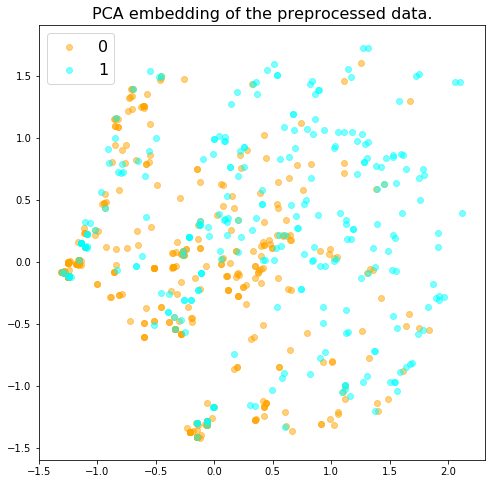

In [80]:
xa, ya = X_train_pca.reshape(-1, 2).T.tolist()

xa_0 = np.array(xa)[y_train.values==0]
ya_0 = np.array(ya)[y_train.values==0]
xa_1 = np.array(xa)[y_train.values==1]
ya_1 = np.array(ya)[y_train.values==1]

plt.figure(figsize=(8, 8))
plt.scatter(xa_0, ya_0, c='orange', alpha=0.5, label='0')
plt.scatter(xa_1, ya_1, c='cyan', alpha=0.5, label='1')
plt.title('PCA embedding of the preprocessed data.', {'fontsize': 16})
plt.legend(fontsize = 16)
plt.show()

*t-SNE*

In [81]:
X_train_tsne = TSNE(random_state=123).fit_transform(X_train_2.toarray())
X_train_tsne.shape

(712, 2)

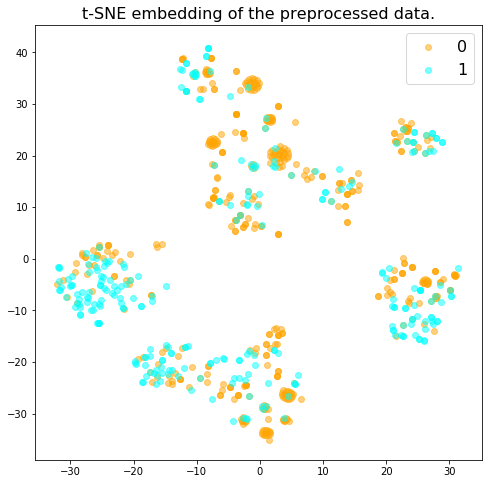

In [82]:
xb, yb = X_train_tsne.reshape(-1, 2).T.tolist()

xb_0 = np.array(xb)[y_train.values==0]
yb_0 = np.array(yb)[y_train.values==0]
xb_1 = np.array(xb)[y_train.values==1]
yb_1 = np.array(yb)[y_train.values==1]

plt.figure(figsize=(8, 8))
plt.scatter(xb_0, yb_0, c='orange', alpha=0.5, label='0')
plt.scatter(xb_1, yb_1, c='cyan', alpha=0.5, label='1')
plt.title('t-SNE embedding of the preprocessed data.', {'fontsize': 16})
plt.legend(fontsize = 16)
plt.show()

---
### End